In [1]:
# coding=gbk
import os
if os.getcwd()[-9:] == 'notebooks':
    os.chdir("..")
import pickle, datetime, copy, ipyparams
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import utils, utils_eda, evaluator, utils_train
import evaluator as ev
from evaluator import Evaluator


# 文件处理参数
PATH_ORI_DATA = r'C:\Users\lucid\Documents\长江实习\课题之自上而下\data'
## 原始数据文件是否已经更新
if_update = False
## 预处理逻辑(参数)变更/缓存的pickle需要更新时，设为False
####一定要注意利用的数据格式，避免用本月行情预测本月行情。
use_cache = True
version = ipyparams.notebook_name

## 预处理参数
if_cls = True
align_to = 'month'
use_lag_x = 15
begT = '2004-01'
endT = datetime.date.today()

## 滚动训练次数
n_splits = 6

/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
X, y_ret = utils.get_preproc_data(PATH_ORI_DATA, if_update, use_cache, use_lag_x, align_to, begT, endT)
if if_cls:
    y_cls = utils.reg_to_class(y_ret, 3)
    y = y_cls
else:
    y = y_ret

data pickle loaded


In [3]:
tscv = TimeSeriesSplit(n_splits=n_splits)
models_list = {}
# 原始的Xy切片之前一定要deepcopy，否则可能莫名其妙篡改原始数据
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, y_train = X.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[train_index, :]
        print("/nTRAIN period:", str(X_train.index[0]), '->', str(X_train.index[-1]), "\nStart training.......................")
        # 因为每个时间段筛选出的特征不一样，所以必须重新get dump，为了节省时间调试可以False force_train
        models = utils_train.get_models_dump(X_train, y_train, pipe='cls', version=version, force_train=True, same_model=True)
        models_list[str(X_train.index[-1])]=models

/nTRAIN period: 2006-12 -> 2016-01 
Start training.......................
...initializing MacroFE


/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


...transforming MacroFE
model 0 pickle saved and appended
...transforming MacroFE
model 1 pickle saved and appended
...transforming MacroFE
model 2 pickle saved and appended
...transforming MacroFE
model 3 pickle saved and appended
...transforming MacroFE
model 4 pickle saved and appended
...transforming MacroFE
model 5 pickle saved and appended
...transforming MacroFE
model 6 pickle saved and appended
...transforming MacroFE
model 7 pickle saved and appended
...transforming MacroFE
model 8 pickle saved and appended
...transforming MacroFE
model 9 pickle saved and appended
/nTRAIN period: 2006-12 -> 2018-03 
Start training.......................
...transforming MacroFE
model 0 pickle saved and appended
...transforming MacroFE
model 1 pickle saved and appended
...transforming MacroFE
model 2 pickle saved and appended
...transforming MacroFE
model 3 pickle saved and appended
...transforming MacroFE
model 4 pickle saved and appended
...transforming MacroFE
model 5 pickle saved and appende

In [4]:
evalor_list = []
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, X_test = X.copy(deep=True).iloc[train_index, :], X.copy(deep=True).iloc[test_index, :]
        y_train, y_test = y.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[test_index, :]
        y_test_ret = y_ret.copy(deep=True).loc[y_test.index, :]
        print("\nTEST period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "\nStart testing...........................")
        # 增加测试集长度使得FE得以进行
        X_test_long = utils.add_2years_test(X_train, X_test)

        evalor = Evaluator(models_list[X_train.index[-1]], if_cls, X_test_long, y_test, y_test_ret, X_train, y_train)
        evalor_list.append(evalor)
        print("Test period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "的年化超额收益为:", str(evalor.excess_ann_ret))
        


TEST period: 2016-02 -> 2018-03 
Start testing...........................

predicting test set for asset 0
...transforming MacroFE
第0个资产的样本外 accuracy score: 0.38461538461538464

predicting test set for asset 1
...transforming MacroFE
第1个资产的样本外 accuracy score: 0.5

predicting test set for asset 2
...transforming MacroFE
第2个资产的样本外 accuracy score: 0.46153846153846156

predicting test set for asset 3
...transforming MacroFE
第3个资产的样本外 accuracy score: 0.34615384615384615

predicting test set for asset 4
...transforming MacroFE
第4个资产的样本外 accuracy score: 0.19230769230769232

predicting test set for asset 5
...transforming MacroFE
第5个资产的样本外 accuracy score: 0.15384615384615385

predicting test set for asset 6
...transforming MacroFE
第6个资产的样本外 accuracy score: 0.34615384615384615

predicting test set for asset 7
...transforming MacroFE
第7个资产的样本外 accuracy score: 0.3076923076923077

predicting test set for asset 8
...transforming MacroFE
第8个资产的样本外 accuracy score: 0.4230769230769231

predicting test

In [5]:
exc_rets = [i.excess_ann_ret for i in evalor_list]
port_ws, bench_ws = [i.port_worth for i in evalor_list], [i.bench_worth for i in evalor_list]
scoress = [i.scores for i in evalor_list]

In [6]:
for i in range(0, len(exc_rets)):    
    print(str(port_ws[i].index[0]), '->', str(port_ws[i].index[-1]), "的年化超额收益为:")
    print(exc_rets[i])

2016-02 -> 2018-03 的年化超额收益为:
return   -0.051336
dtype: float64
2018-04 -> 2020-05 的年化超额收益为:
return    0.052644
dtype: float64
2020-06 -> 2022-07 的年化超额收益为:
return   -0.039432
dtype: float64


In [7]:
score_df = pd.DataFrame()
for i in scoress:
    score_df = pd.concat([score_df, pd.Series(i)], axis=1)
score_df

,0,0,0
第0个资产:,0.384615,0.423077,0.269231
第1个资产:,0.500000,0.500000,0.423077
第2个资产:,0.461538,0.384615,0.230769
第3个资产:,0.346154,0.307692,0.153846
第4个资产:,0.192308,0.192308,0.346154
第5个资产:,0.153846,0.269231,0.192308
第6个资产:,0.346154,0.576923,0.384615
第7个资产:,0.307692,0.653846,0.423077
第8个资产:,0.423077,0.269231,0.269231
第9个资产:,0.846154,0.884615,0.346154


In [8]:
for id, row in score_df.iterrows():
    print(id)
    print(row.mean())

第0个资产:
0.358974358974359
第1个资产:
0.4743589743589744
第2个资产:
0.35897435897435903
第3个资产:
0.2692307692307692
第4个资产:
0.2435897435897436
第5个资产:
0.20512820512820515
第6个资产:
0.4358974358974359
第7个资产:
0.4615384615384615
第8个资产:
0.3205128205128205
第9个资产:
0.6923076923076924


[]

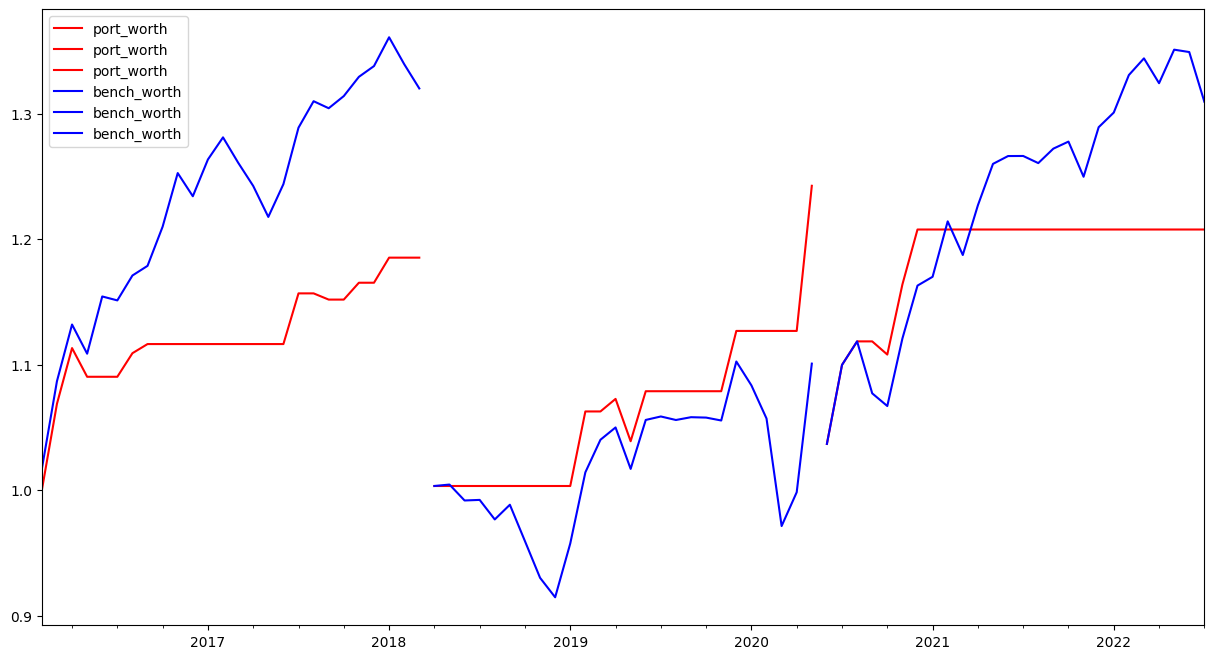

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in port_ws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in bench_ws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [10]:
con_pws = ev.get_continue_worth(port_ws)
con_bws = ev.get_continue_worth(bench_ws)

[]

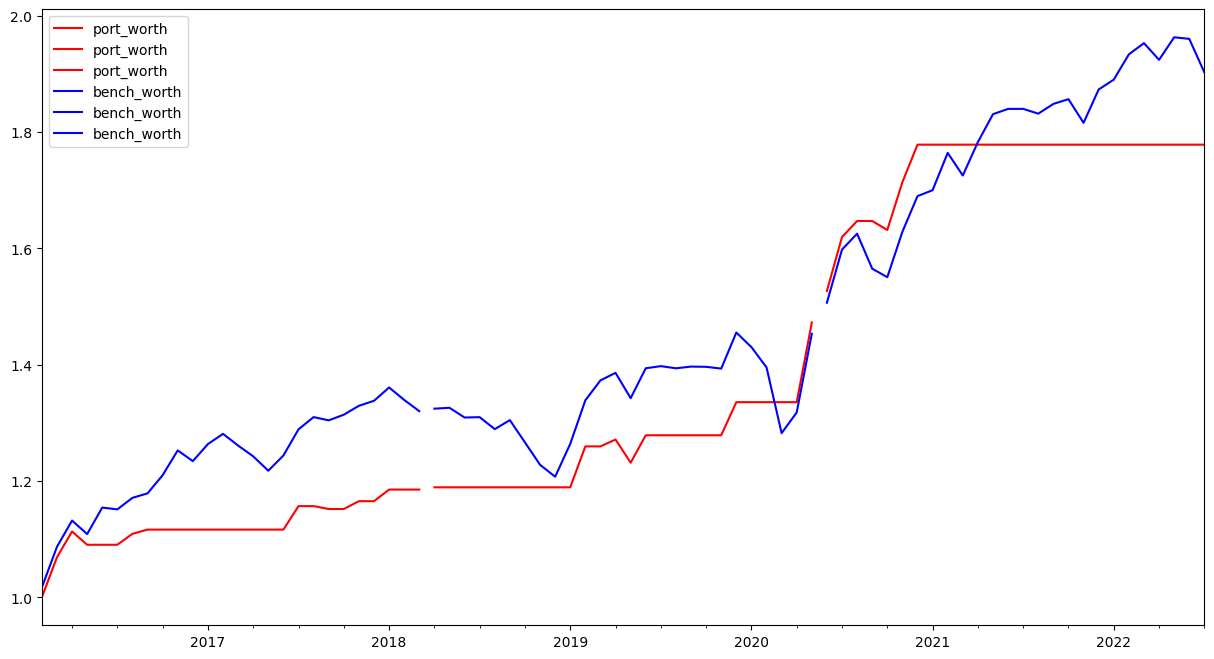

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in con_pws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in con_bws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [14]:
models_list.keys()

dict_keys([Period('2016-01', 'M'), Period('2018-03', 'M'), Period('2020-05', 'M')])

In [25]:
values=models_list[pd.Period('2016-01', 'M')][9][-1][-1].feature_importances_

In [40]:
names=models_list[pd.Period('2016-01', 'M')][9][:-1].get_feature_names_out()
names

array(['lr1__self__ridge0__var385(t-4)G0003663_resid',
       'lr1__self__sgd0__var385(t-4)G0003663_resid',
       'lr1__self__rf0__var334(t-14)G0002325_resid',
       'lr1__self__rf0__var391(t-12)G0003650_resid',
       'lr1__self__rf0__var579(t-6)K0182681_returns',
       'lr1__talibFE__27_mom', 'lr1__talibFE__41_mom',
       'lr1__talibFE__43_mom', 'lr1__talibFE__94_mom',
       'lr1__talibFE__117_mom', 'lr1__talibFE__125_yoy',
       'lr1__talibFE__134_mom10', 'lr1__talibFE__152_PPO',
       'lr1__talibFE__160_yoy', 'lr1__talibFE__161_mom',
       'lr1__talibFE__177_rsi6', 'lr1__talibFE__186_mom',
       'lr1__talibFE__206_mom', 'lr1__talibFE__207_mom',
       'lr1__talibFE__229_mom',
       'ridge1__self__ridge0__var65(t-11)M0000705',
       'ridge1__self__ridge0__var385(t-4)G0003663_resid',
       'ridge1__self__sgd0__var65(t-11)M0000705',
       'ridge1__self__sgd0__var385(t-4)G0003663_resid',
       'ridge1__self__rf0__var334(t-14)G0002325_resid',
       'ridge1__self__rf0__var

In [34]:
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
names,lr1__self__ridge0__var385(t-4)G0003663_resid,lr1__self__sgd0__var385(t-4)G0003663_resid,lr1__self__rf0__var334(t-14)G0002325_resid,lr1__self__rf0__var391(t-12)G0003650_resid,lr1__self__rf0__var579(t-6)K0182681_returns,lr1__talibFE__27_mom,lr1__talibFE__41_mom,lr1__talibFE__43_mom,lr1__talibFE__94_mom,lr1__talibFE__117_mom,...,mi1__talibFE__26_mom10,mi1__talibFE__28_rsi14,mi1__talibFE__52_macdsignal,mi1__talibFE__95_macdsignal,mi1__talibFE__114_mom10,mi1__talibFE__156_rsi14,mi1__talibFE__192_mom10,mi1__talibFE__194_rsi14,mi1__talibFE__231_rsi14,mi1__talibFE__236_rsi14
values,0.000743,0.00109,0.00075,0.001808,0.004344,0.002592,0.002891,0.006556,0.002752,0.000845,...,0.003891,0.011313,0.00302,0.002,0.004105,0.011757,0.00562,0.013617,0.009417,0.000472


In [37]:
fea_imp.sort_values(by='values', axis=1, ascending=False)

,68,88,69,89,67,63,80,81,98,82,...,41,119,42,16,12,31,47,52,57,77
names,rf1__self__gbr0__var407(t-2)G0003681_resid,gbr1__self__gbr0__var407(t-2)G0003681_resid,rf1__self__mi0__var407(t-2)G0003681_resid,gbr1__self__mi0__var407(t-2)G0003681_resid,rf1__self__gbr0__var514(t-6)S0031648_resid,rf1__self__ridge0__var385(t-12)G0003663_resid,gbr1__self__lr0__var339(t-2)G0003878_resid,gbr1__self__ridge0__var385(t-12)G0003663_resid,gbr1__talibFE__196_rsi6,gbr1__self__rf0__var514(t-6)S0031648_resid,...,sgd1__self__ridge0__var316(t-7)G1143819_resid,mi1__talibFE__236_rsi14,sgd1__self__sgd0__var316(t-7)G1143819_resid,lr1__talibFE__186_mom,lr1__talibFE__152_PPO,ridge1__talibFE__117_mom,sgd1__talibFE__120_PPO,sgd1__talibFE__152_PPO,sgd1__talibFE__211_yoy,rf1__talibFE__134_rsi14
values,0.055216,0.051764,0.044659,0.04328,0.041358,0.040732,0.036441,0.034318,0.033752,0.031917,...,0.000535,0.000472,0.00046,0.00043,0.000402,0.000272,0.0,0.0,0.0,0.0


In [38]:
values=models_list[pd.Period('2018-03', 'M')][9][-1][-1].feature_importances_
names=models_list[pd.Period('2018-03', 'M')][9][:-1].get_feature_names_out()
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])
fea_imp.sort_values(by='values', axis=1, ascending=False)

,68,88,69,89,67,63,80,81,98,82,...,41,119,42,16,12,31,47,52,57,77
names,rf1__self__gbr0__var407(t-2)G0003681_resid,gbr1__self__gbr0__var407(t-2)G0003681_resid,rf1__self__mi0__var407(t-2)G0003681_resid,gbr1__self__mi0__var407(t-2)G0003681_resid,rf1__self__gbr0__var514(t-6)S0031648_resid,rf1__self__ridge0__var385(t-12)G0003663_resid,gbr1__self__lr0__var339(t-2)G0003878_resid,gbr1__self__ridge0__var385(t-12)G0003663_resid,gbr1__talibFE__196_rsi6,gbr1__self__rf0__var514(t-6)S0031648_resid,...,sgd1__self__ridge0__var316(t-7)G1143819_resid,mi1__talibFE__236_rsi14,sgd1__self__sgd0__var316(t-7)G1143819_resid,lr1__talibFE__186_mom,lr1__talibFE__152_PPO,ridge1__talibFE__117_mom,sgd1__talibFE__120_PPO,sgd1__talibFE__152_PPO,sgd1__talibFE__211_yoy,rf1__talibFE__134_rsi14
values,0.055216,0.051764,0.044659,0.04328,0.041358,0.040732,0.036441,0.034318,0.033752,0.031917,...,0.000535,0.000472,0.00046,0.00043,0.000402,0.000272,0.0,0.0,0.0,0.0


In [39]:
values=models_list[pd.Period('2020-05', 'M')][9][-1][-1].feature_importances_
names=models_list[pd.Period('2020-05', 'M')][9][:-1].get_feature_names_out()
fea_imp = pd.DataFrame([names, values], index=['names', 'values'])
fea_imp.sort_values(by='values', axis=1, ascending=False)

,68,88,69,89,67,63,80,81,98,82,...,41,119,42,16,12,31,47,52,57,77
names,rf1__self__gbr0__var407(t-2)G0003681_resid,gbr1__self__gbr0__var407(t-2)G0003681_resid,rf1__self__mi0__var407(t-2)G0003681_resid,gbr1__self__mi0__var407(t-2)G0003681_resid,rf1__self__gbr0__var514(t-6)S0031648_resid,rf1__self__ridge0__var385(t-12)G0003663_resid,gbr1__self__lr0__var339(t-2)G0003878_resid,gbr1__self__ridge0__var385(t-12)G0003663_resid,gbr1__talibFE__196_rsi6,gbr1__self__rf0__var514(t-6)S0031648_resid,...,sgd1__self__ridge0__var316(t-7)G1143819_resid,mi1__talibFE__236_rsi14,sgd1__self__sgd0__var316(t-7)G1143819_resid,lr1__talibFE__186_mom,lr1__talibFE__152_PPO,ridge1__talibFE__117_mom,sgd1__talibFE__120_PPO,sgd1__talibFE__152_PPO,sgd1__talibFE__211_yoy,rf1__talibFE__134_rsi14
values,0.055216,0.051764,0.044659,0.04328,0.041358,0.040732,0.036441,0.034318,0.033752,0.031917,...,0.000535,0.000472,0.00046,0.00043,0.000402,0.000272,0.0,0.0,0.0,0.0


In [ ]:
不同period的feature imp竟然完全没有变化，肯定有问题

In [41]:
__name__

'__main__'

In [45]:
import ipyparams


<IPython.core.display.Javascript object>

In [43]:
pip install ipyparams

  Preparing metadata (setup.py) ... done
  Created wheel for ipyparams: filename=ipyparams-0.2.1-py3-none-any.whl size=2746 sha256=b970c82d743560d406f0730dce2d6018016ceab9aea35cb0138f6e0fd01c1580
  Stored in directory: /Users/Gary/Library/Caches/pip/wheels/90/d9/ee/860f6045703143ddcdfcc5ce55bc96c3326392596f5b467891
Successfully built ipyparams
Note: you may need to restart the kernel to use updated packages.


In [46]:
ipyparams.notebook_name

'featcheck_RF_0926.ipynb'